In [10]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from copy import deepcopy
from itertools import combinations
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from networkx.algorithms.community import louvain_communities as louvain

FORMAT = 'png'

mpl.rcParams['savefig.format'] = FORMAT
%matplotlib inline
%config InlineBackend.figure_format = FORMAT

In [11]:
class MyMinMaxScaler:
    __slots__ = ['min', 'max']

    def __init__(self):
        self.max = np.inf
        self.min = np.array([-np.inf])

    def fit(self, points):
        self.min = np.min(points, axis=0)
        self.max = max(np.max(points, axis=0) - self.min)

    def transform(self, points):
        return np.apply_along_axis(lambda point: (point - self.min) / self.max, 1, points)

    def fit_transform(self, points):
        self.fit(points)

        return self.transform(points)

    def reset_radius(self, radius):
        return radius / self.max


def euclidean_distance(first_point, second_point, power):
    return (np.sum(np.fabs(first_point - second_point)**power))**(1 / power)


def get_edge(first_id, first_point, second_id, second_point, radius, power):
    if euclidean_distance(first_point, second_point, power) <= radius:
        return first_id, second_id


def build_graph(ids, points, radius, power):
    graph = nx.Graph()
    graph.add_nodes_from(ids)
    edges_generator = filter(lambda x: x is not None,
                             (get_edge(*first_info, *second_info, radius, power)
                              for first_info, second_info in combinations(zip(ids, points), 2)))
    graph.add_edges_from(list(edges_generator))

    return graph


def get_cluster_ids(ids, communities):
    tmp_color_dict = {}

    for color_id, community in enumerate(communities):
        tmp_color_dict.update(dict(zip(community, [color_id] * len(community))))

    return [tmp_color_dict[_id] for _id in ids]

In [12]:
RADIUS = 2000.
PATH = r'/Users/aleksandr_viatkin/PycharmProjects/ntc/Скважины-кусты_Спорышевское мр..xlsx'

In [13]:
data = pd.read_excel(PATH, engine='openpyxl')
data.columns = ['id', 'bush', 'x', 'y', 'deposit']

In [14]:
scaler = MyMinMaxScaler()
points = scaler.fit_transform(data.loc[:, ['x', 'y']].values)
RADIUS = scaler.reset_radius(RADIUS)

In [24]:
graph = build_graph(data.id.values, points, RADIUS, 1)
communities = louvain(graph)

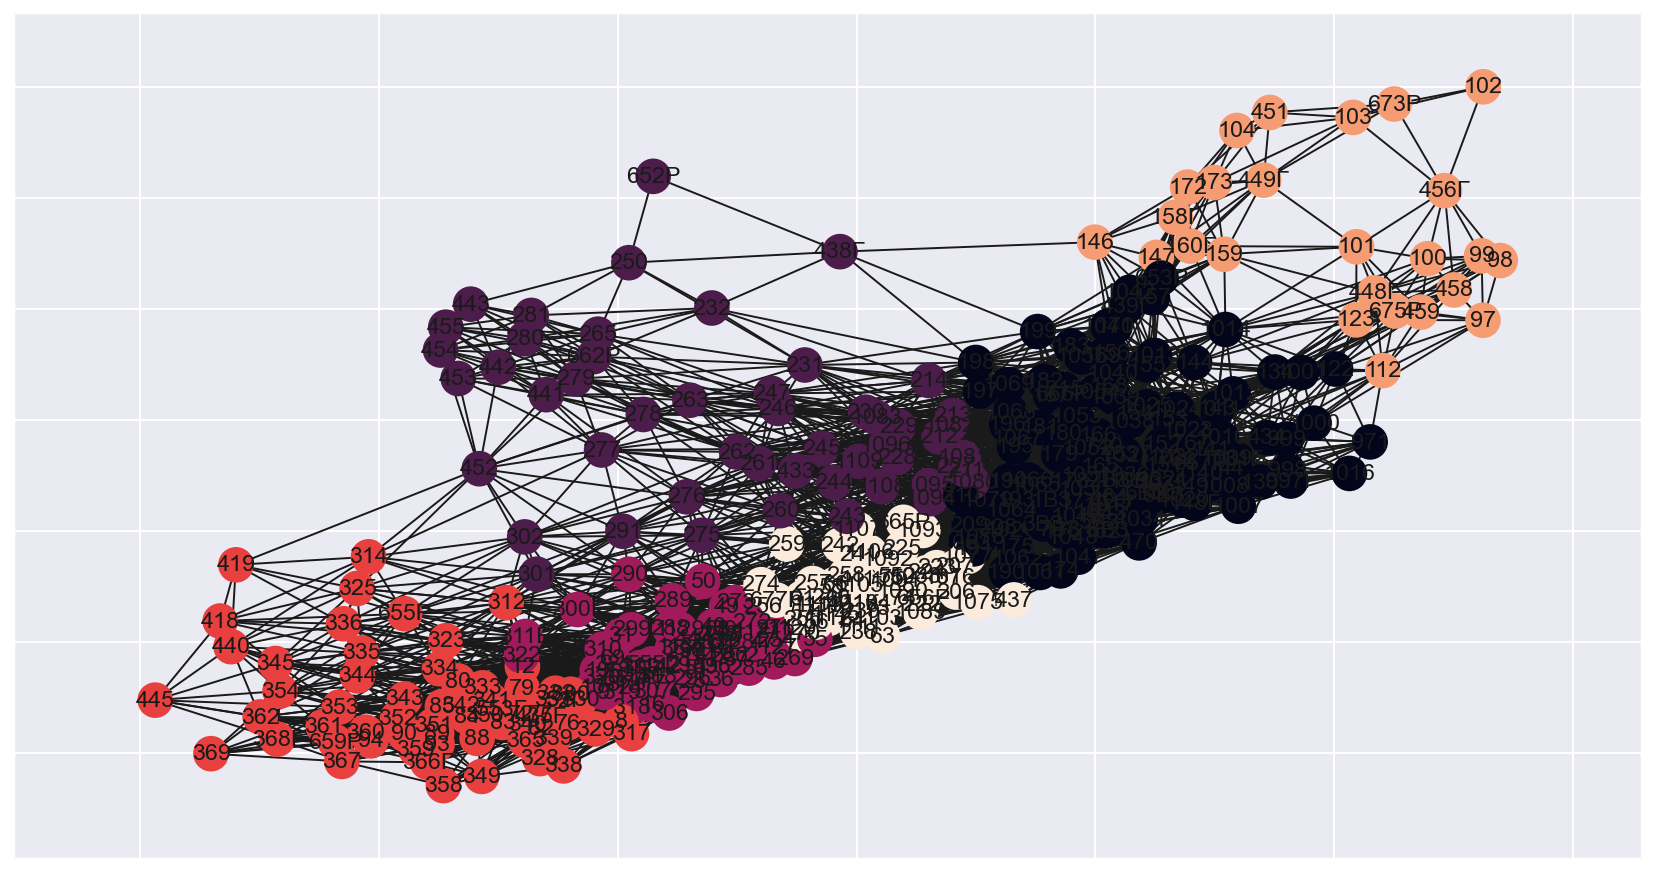

In [25]:
nx.draw_networkx(graph, node_color=get_cluster_ids(graph, communities))
plt.savefig(f'radius_{RADIUS}.{FORMAT}')
plt.show()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       392 non-null    object
 1   bush     392 non-null    object
 2   x        392 non-null    int64 
 3   y        392 non-null    int64 
 4   deposit  392 non-null    object
dtypes: int64(2), object(3)
memory usage: 15.4+ KB


In [18]:
data['normalized_x'] = points[:, 0]
data['normalized_y'] = points[:, 1]

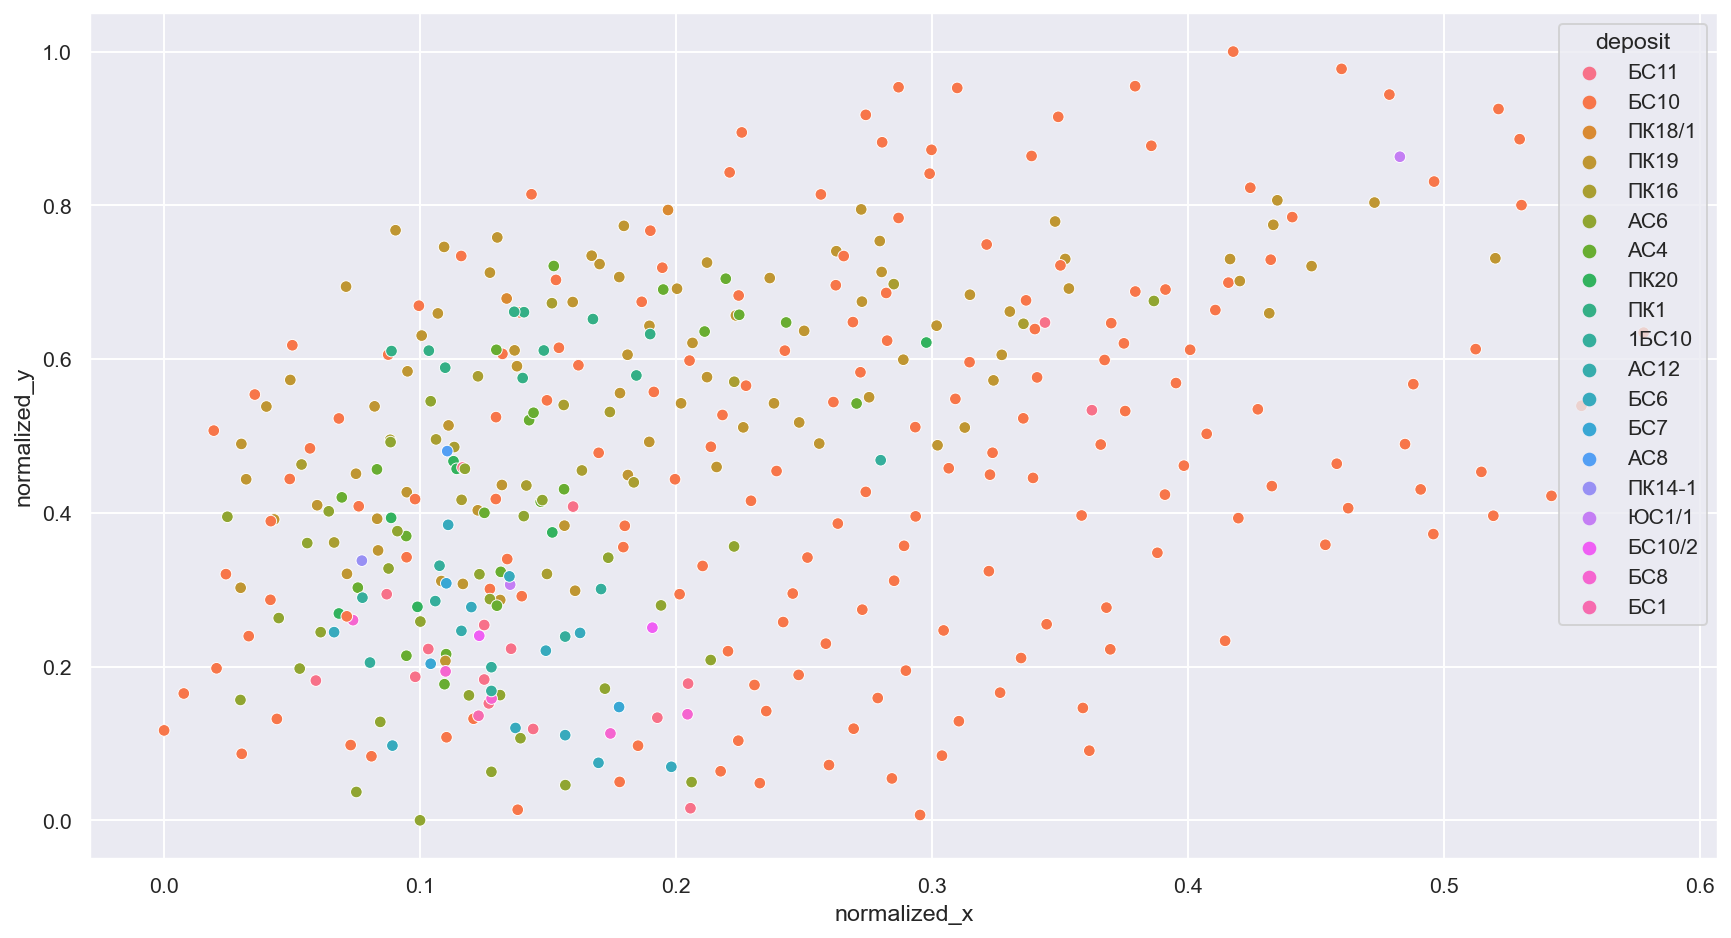

In [19]:
sns.set(rc = {'figure.figsize':(15,8), 'figure.dpi': 140})
sns.scatterplot(data=data, x='normalized_x', y='normalized_y', hue='deposit')
plt.savefig('data_representation' + f'.{FORMAT}')
plt.show()

In [20]:
data['cluster_id'] = get_cluster_ids(data.id.values, communities)

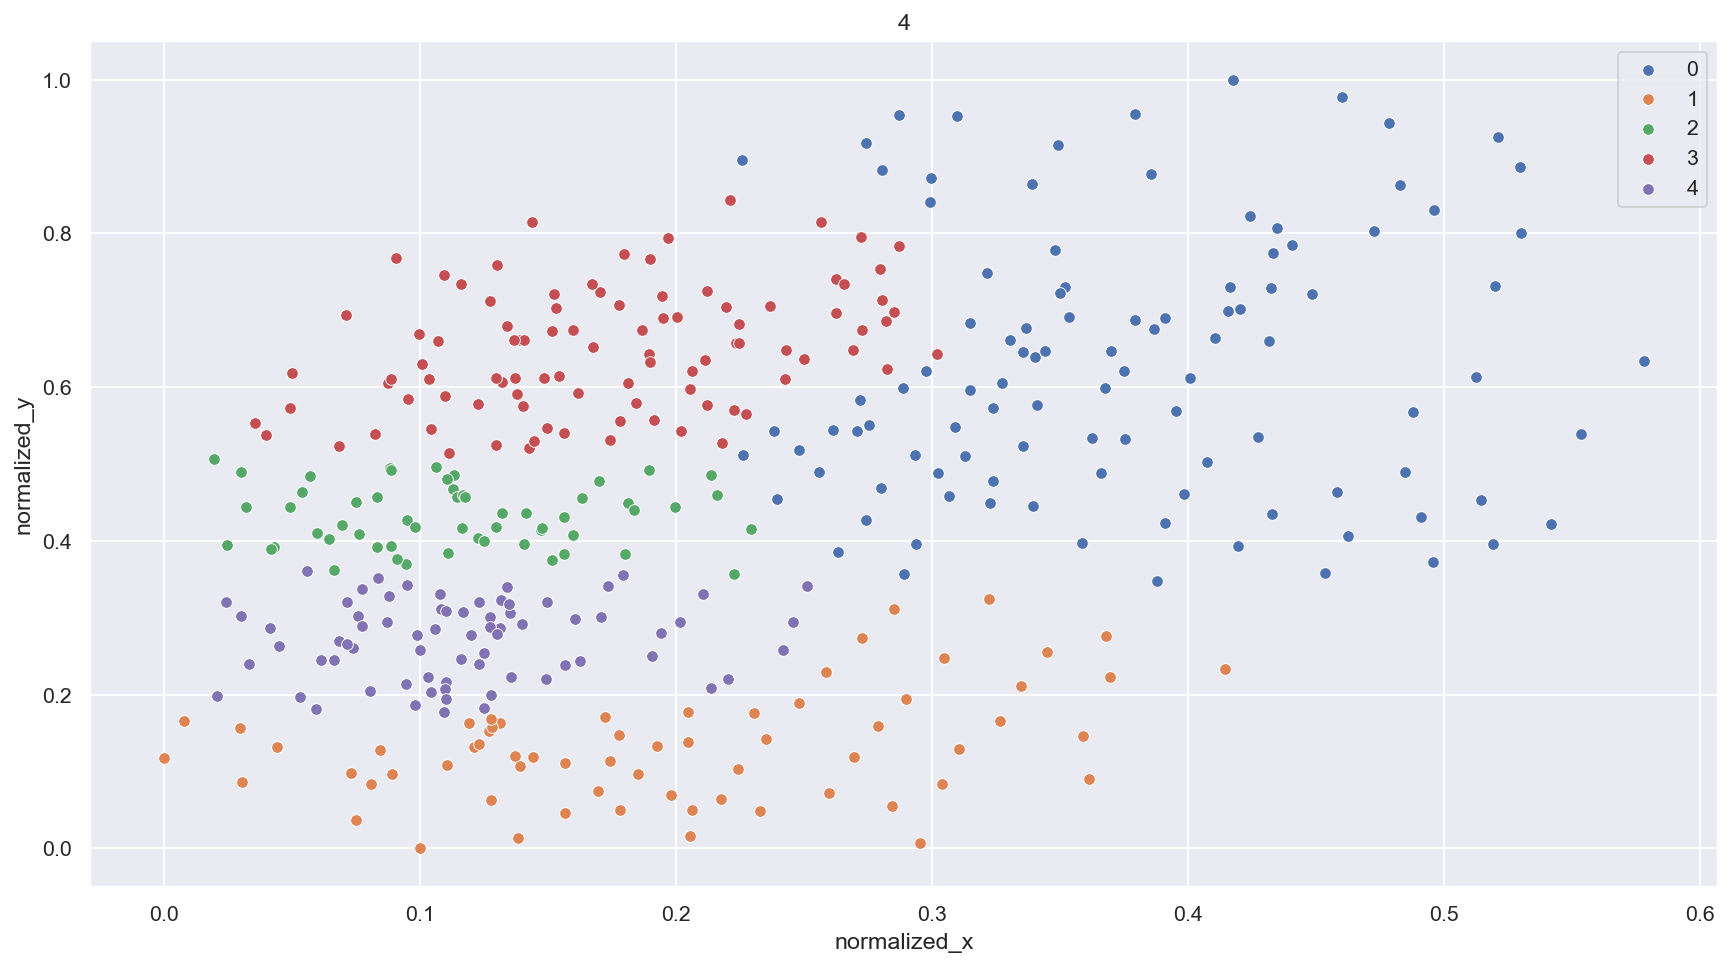

In [26]:
clusters = set(data.cluster_id.values)

for cluster_id in clusters:
    indices = data.cluster_id == cluster_id
    x = data.normalized_x[indices]
    y = data.normalized_y[indices]
    sns.scatterplot(x=x, y=y)
    plt.title(cluster_id)

plt.savefig('clusterization' + f'.{FORMAT}')
plt.legend(clusters)
plt.show()

In [194]:
import os
import json
import logging
import numpy as np
import pandas as pd
import logging.config
import networkx as nx
import scipy.stats as st
import matplotlib as mpl

from tqdm import tqdm
from math import ceil
from functools import partial
from typing import Union, List
from scipy.spatial import Delaunay
from sklearn.mixture import GaussianMixture
from itertools import product, combinations, chain
from scipy.optimize import minimize as func_minimize
from collections import namedtuple, Counter, defaultdict
from networkx.algorithms.community import louvain_communities as louvain

# constants
RADIUS = 2000.
PATH = r'/Users/aleksandr_viatkin/PycharmProjects/ntc/Скважины-кусты_Спорышевское мр..xlsx'
BUSH_COST = 100  # mln rubles
BASE_DRILL_COST = 0  # mln rubles
DRILL_METER_COST = 1  # mln rubles
MAX_NUM_OF_WELLS_ON_BUSH = 8
MAX_TIME = 7200
DENOMINATOR = 10
NUMBER_OF_SAMPLES = 100
PROPORTION = 0.8
MAX_POINT_SIZE = 6
PATH_TO_DATA_FOLDER = 'data'
PATH_TO_PLOTS_FOLDER = 'plots'
ITERATIONS_NUM = 1

max_clusters = 1

dist = partial(euclidean_distance, power=2)


def get_all_distances(wells):
    return [dist(first_point, second_point) for first_point, second_point in combinations(wells, 2)]


def get_grid_step(wells):
    distances = get_all_distances(wells)
    global DENOMINATOR

    return np.median(distances) / DENOMINATOR


def simple_grid_bush_generator(wells):
    min_x, min_y = np.min(wells, axis=0)
    max_x, max_y = np.max(wells, axis=0)
    grid_step = get_grid_step(wells)
    x_num_points = ceil((max_x - min_x) / grid_step)
    y_num_points = ceil((max_y - min_y) / grid_step)
    bush_coords = np.array(
        list(product(np.linspace(min_x, max_x, x_num_points), np.linspace(min_y, max_y, y_num_points)))
    )
    convex_hull = Delaunay(wells)
    bush_coords = bush_coords[convex_hull.find_simplex(bush_coords) >= 0]
    
    return bush_coords


def simple_stochastic_bush_generator(wells):
    global RADIUS
    global PROPORTION
    global NUMBER_OF_SAMPLES
    sigma = 0.14 / 100

    bushes = []

    for well in wells:
        distribution = st.multivariate_normal(mean=well, cov=np.eye(len(well)) * sigma)
        curr_bushes = distribution.rvs(size=(NUMBER_OF_SAMPLES, 1)).tolist()
        bushes.extend(curr_bushes)

    bushes = np.array(bushes)
    convex_hull = Delaunay(wells)
    bushes = bushes[convex_hull.find_simplex(bushes) >= 0]
    indices = np.random.choice(list(range(len(bushes))), size=ceil(len(wells) * PROPORTION), replace=False)
    bushes = bushes[indices]

    return bushes


def generate_bushes_from_gm(means, covs, weights, total_number_of_points):
    dists_ids = np.random.choice(list(range(len(weights))), size=total_number_of_points, p=weights)
    bushes = []
    id_to_number_of_points = dict(Counter(dists_ids))

    for dist_id, number_of_points in id_to_number_of_points.items():
        curr_dist = st.multivariate_normal(mean=means[dist_id], cov=covs[dist_id])
        bushes.extend(curr_dist.rvs(size=number_of_points).tolist())

    return np.array(bushes)


def em_stochastic_bush_generator(wells):
    number_of_clusters = 1
    components_range = list(range(1, 8))
    bic = []

    for number_of_components in components_range:
        gmm = GaussianMixture(n_components=number_of_components)
        gmm.fit(wells)
        bic.append(gmm.bic(wells))

    number_of_clusters = max(number_of_clusters, components_range[np.argmin(bic)])
    gmm = GaussianMixture(n_components=number_of_clusters).fit(wells)

    global PROPORTION
    number_of_points = ceil(len(wells) * PROPORTION)
    bushes = generate_bushes_from_gm(gmm.means_, gmm.covariances_, gmm.weights_, number_of_points)
    convex_hull = Delaunay(wells)
    bushes = bushes[convex_hull.find_simplex(bushes) >= 0]

    return bushes

In [195]:
RADIUS

2000.0

In [196]:
points = data.loc[:, ['normalized_x', 'normalized_y']].values

In [197]:
FORMAT

'png'

In [198]:
def plot_grid(wells, bushes, name):
    sns.scatterplot(x=wells[:, 0], y=wells[:, 1], color='darkorange')
    sns.scatterplot(x=bushes[:, 0], y=bushes[:, 1], color='maroon')
    plt.savefig(name + f'.{FORMAT}')
    plt.show()

In [199]:
regular_grid = simple_grid_bush_generator(points)
stochatic_grid = simple_stochastic_bush_generator(points)
em_grid = em_stochastic_bush_generator(points)

In [224]:
sns.set(rc = {'figure.figsize':(6,8), 'figure.dpi': 50})

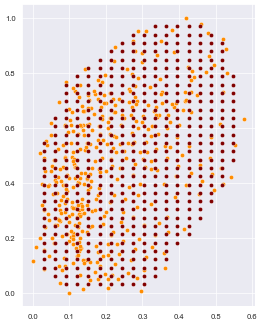

In [225]:
plot_grid(points, regular_grid, 'simple_grid_bush_generator')

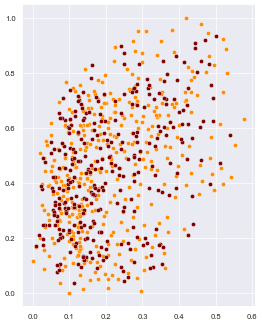

In [226]:
plot_grid(points, stochatic_grid, 'simple_stochastic_bush_generator')

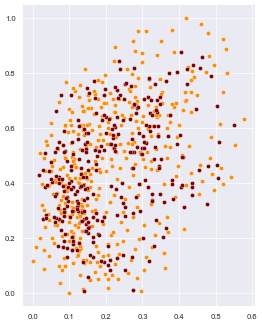

In [227]:
plot_grid(points, em_grid, 'em_stochastic_bush_generator')

In [214]:
from mip import Model, BINARY, xsum, LinExpr, Var, maximize, minimize

ModuleNotFoundError: No module named 'mip'

In [215]:
data

,id,bush,x,y,deposit,normalized_x,normalized_y,cluster_id
0,10,2,524959,7015990,БС11,0.125081,0.183164,4
1,100,25,528079,7026172,БС10,0.349364,0.915103,1
2,1000,23,525958,7024486,ПК18/1,0.196895,0.793904,0
3,1001,23,527008,7024497,ПК19,0.272374,0.794695,0
4,1007,21,524208,7023100,ПК19,0.071095,0.694271,0
...,...,...,...,...,...,...,...,...
387,99,25,527530,7026695,БС10,0.309899,0.952699,1
388,997Г,21,524741,7023818,ПК19,0.109410,0.745885,0
389,998,21,525030,7023990,ПК19,0.130185,0.758249,0
390,999,21,525718,7024199,ПК19,0.179642,0.773273,0


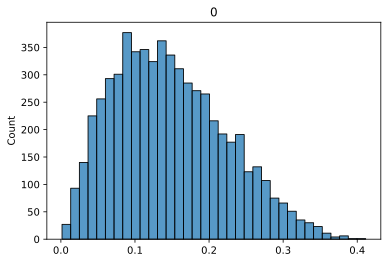

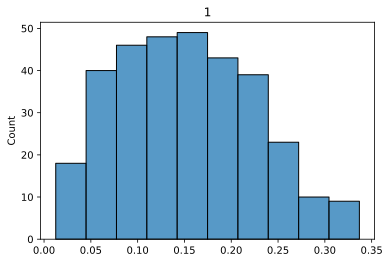

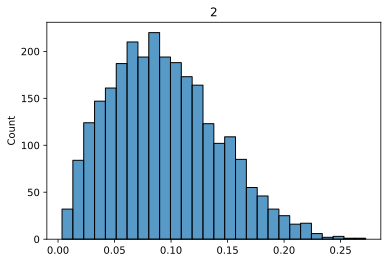

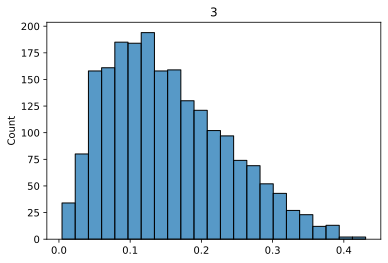

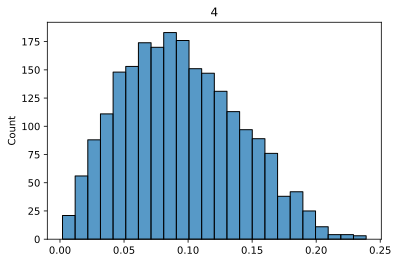

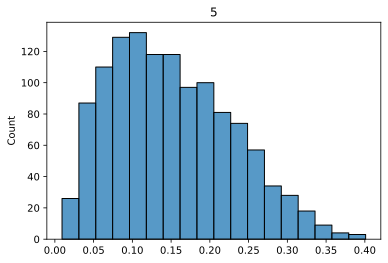

In [15]:
from itertools import combinations
from functools import partial

dist = partial(euclidean_distance, power=2)

def get_all_distances(points):
    return [dist(first_point, second_point) for first_point, second_point in combinations(points, 2)]

def plot_points_dist_hist(distances, cluster_id):
    sns.histplot(distances)
    plt.title(cluster_id)
    plt.show()
    
clusters = set(data.cluster_id.values)
grid_step_dict = dict(zip(clusters, [0] * len(clusters)))

for cluster_id in clusters:
    points = data[data.cluster_id == cluster_id].loc[:, ['normalized_x', 'normalized_y']].values
    distances = get_all_distances(points)
    grid_step_dict[cluster_id] = np.median(distances) / 4
    plot_points_dist_hist(distances, cluster_id)

In [16]:
grid_step_dict

{0: 0.03477731812708685,
 1: 0.03746894653320042,
 2: 0.022411792711318917,
 3: 0.034819283238593145,
 4: 0.022746086095725274,
 5: 0.03589341823013564}

In [ ]:
clusters = set(data.cluster_id.values)
convex_hulls = dict()

for cluster_id in clusters:
    current_points = data[data.cluster_id == cluster_id].loc[:, ['normalized_x', 'normalized_y']].values
    print(len(current_points))
    print(len(np.unique(current_points, axis=0)))
    min_x, min_y = np.min(current_points, axis=0)
    max_x, max_y = np.max(current_points, axis=0)
    x_num_points = ceil((max_x - min_x) / grid_step_dict[cluster_id])
    y_num_points = ceil((max_y - min_y) / grid_step_dict[cluster_id])
    bush_coords = np.array(list(product(np.linspace(min_x, max_x, x_num_points), np.linspace(min_y, max_y, y_num_points))))
    convex_hull = Delaunay(current_points)
    bush_coords = bush_coords[convex_hull.find_simplex(bush_coords) >= 0]
    print(len(bush_coords))
    print(len(current_points) / len(bush_coords))
    
    nearest_points = []
    
    for curr_bush in bush_coords:
        distances = np.array([dist(curr_bush, point) for point in current_points])
        indices = np.argsort(distances)
        nearest_points.extend(current_points[indices][:12])
    
    print(len(np.unique(np.array(nearest_points), axis=0)))
    print(end='\n\n\n')

# TODO

make function get_nearest_points_ids faster (but it is not very usefull because it is not bottleneck of algorithm)

In [14]:
from math import ceil
from itertools import product
from collections import namedtuple
from scipy.spatial import Delaunay
from itertools import combinations
from functools import partial


MAX_NUM_OF_WELLS_ON_BUSH = 12

dist = partial(euclidean_distance, power=2)


def get_all_distances(wells):
    return [dist(first_point, second_point) for first_point, second_point in combinations(wells, 2)]


def get_grid_step(wells):
    distances = get_all_distances(wells)
    
    return np.median(distances) / 4


def get_bushes_coordinates(wells):
    min_x, min_y = np.min(wells, axis=0)
    max_x, max_y = np.max(wells, axis=0)
    grid_step = get_grid_step(wells)
    x_num_points = ceil((max_x - min_x) / grid_step)
    y_num_points = ceil((max_y - min_y) / grid_step)
    bush_coords = np.array(list(product(np.linspace(min_x, max_x, x_num_points), np.linspace(min_y, max_y, y_num_points))))
    convex_hull = Delaunay(wells)
    bush_coords = bush_coords[convex_hull.find_simplex(bush_coords) >= 0]
    
    return bush_coords


def get_nearest_points_ids(wells_df, bush_coords):
    nearest_points = []
    wells = wells_df.loc[:, ['normalized_x', 'normalized_y']].values
    
    for curr_bush in bush_coords:
        distances = np.array([dist(curr_bush, well) for well in wells])
        indices = np.argsort(distances)[:MAX_NUM_OF_WELLS_ON_BUSH]
        nearest_points.append(wells_df.iloc[indices].id.values)
        
    return nearest_points


def base_worker(data):
    wells = data.loc[:, ['normalized_x', 'normalized_y']].values
    bush_coords = get_bushes_coordinates(wells)
    nearest_points = get_nearest_points_ids(wells_df, bush_coords)


def read_data():
    data = pd.read_excel(PATH, engine='openpyxl')
    data.columns = ['id', 'bush', 'x', 'y', 'deposit']
    
    return data


def get_louvain_clusters(ids, points):
    graph = build_graph(ids, points, RADIUS, 1)
    communities = louvain(graph)
    
    return get_cluster_ids(ids, communities)


def get_default_clusters(ids, points):
    return [0] * len(ids)


def clusterization_worker(get_clusters):
    data = read_data()
    
    scaler = MyMinMaxScaler()
    points = scaler.fit_transform(data.loc[:, ['x', 'y']].values)
    global RADIUS
    RADIUS = scaler.reset_radius(RADIUS)
    
    data['cluster_id'] = get_clusters(data.id.values, points)
    data['normalized_x'] = points[:, 0]
    data['normalized_y'] = points[:, 1]
    
    clusters = set(data.cluster_id.values)
    
    for cluster_id in clusters:
        wells_df = data[data.cluster_id == cluster_id]
        wells = wells_df.loc[:, ['normalized_x', 'normalized_y']].values
        bush_coords = get_bushes_coordinates(wells)
        nearest_points = get_nearest_points_ids(wells_df, bush_coords)
        print(nearest_points)
        
clusterization_worker(get_louvain_clusters)

ZeroDivisionError: division by zero

In [19]:
Bush = namedtuple('Bush', ['x', 'y', 'name', 'mip_variable'])
Well = namedtuple('Well', ['x', 'y', 'name', 'mip_variable'])

In [ ]:
def prepare_model(wells_df):
    

In [50]:
from mip import Model, MAXIMIZE, CBC, BINARY, OptimizationStatus
model = Model(sense=MAXIMIZE, solver_name=CBC)
x = model.add_var(name='x', var_type=BINARY)
y = model.add_var(name='y', var_type=BINARY)

In [52]:
print(x.x)

None


In [53]:
model += x == 1
model += x + y <= 1
model.objective = x + y
status = model.optimize(max_seconds=60)
status == OptimizationStatus.OPTIMAL

True

In [54]:
print(x.x)

1.0


In [24]:
status.value

0

In [18]:
tmp = x == 1

In [20]:
print(tmp)

+ x  = 1


In [25]:
values = [var.x for var in model.vars]

In [26]:
values

[1.0, 0.0]

In [30]:
list(product([1, -1], repeat=3))

[(1, 1, 1),
 (1, 1, -1),
 (1, -1, 1),
 (1, -1, -1),
 (-1, 1, 1),
 (-1, 1, -1),
 (-1, -1, 1),
 (-1, -1, -1)]

In [40]:
NUM = 3
from collections import Counter

A = [(*x, -1 if sum(x) == NUM else 1) for x in product((1, -1), repeat=NUM)]
b = [-1 * Counter(x)[-1] + 0.1 for x in A]

In [41]:
A

[(1, 1, 1, -1),
 (1, 1, -1, 1),
 (1, -1, 1, 1),
 (1, -1, -1, 1),
 (-1, 1, 1, 1),
 (-1, 1, -1, 1),
 (-1, -1, 1, 1),
 (-1, -1, -1, 1)]

In [42]:
b

[-0.9, -0.9, -0.9, -1.9, -0.9, -1.9, -1.9, -2.9]

In [47]:
from itertools import chain

Point = namedtuple('Point', ['x', 'y'])
points = [Point(1, 2), Point(2, 3)]
Point_ = namedtuple('Point_', ['x', 'y'])
bush = Point_(2, 4)

tmp = list(chain(points, [bush]))

In [49]:
from itertools import filterfalse

list(filter(lambda x: isinstance(x, Point), tmp))

[Point(x=1, y=2), Point(x=2, y=3)]

In [55]:
TMP = namedtuple('TMP', ['variable'])
tmp_x = TMP(x)
tmp_y = TMP(y)
tmp_list = [tmp_x, tmp_y]
lin_expr = xsum(map(lambda x: x.variable, tmp_list))

In [56]:
lin_expr

In [57]:
print(lin_expr)

+ x + y 
